In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from superres import superres_metrics, ssim, psnr
from superres import RRDB_Net, MultiImageToMultiChannel, TwoXModel, TwoYLoss, MultiToMultiImageList
import czifile
from superres.helpers import get_czi_shape_info, build_index
import imageio

datasetname = 'multiframe_001'
data_path = Path('/scratch/bpho')
datasets = data_path/'datasets'
datasources = data_path/'datasources'
dataset = datasets/datasetname

hr_path = dataset/'hr'
lr_path = dataset/'lr'
lr_up_path = dataset/'lr_up'

In [2]:
def map_to_hr(x):
    hr_name = x.relative_to(lr_path)
    return hr_path/hr_name

def get_src(size=128, scale=1):
    if scale != 1: use_lr_path = lr_path
    else: use_lr_path = lr_up_path
        
    def map_to_hr(x):
        hr_name = x.relative_to(use_lr_path)
        return hr_path/hr_name
    
    src = (MultiToMultiImageList.from_folder(use_lr_path, extensions=['.npy'])
           .split_by_folder()
           .label_from_func(map_to_hr))
    return src

def get_data(bs, size, scale=1, max_zoom=1.):
    src = get_src(size, scale=scale)    
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size*scale)
            .databunch(bs=bs).normalize(do_y=True))
    return data

In [3]:
bs = 4
size = 256
data = get_data(bs, size, scale=4)

in_c = 3
out_c = 1
nf = gcval = 16
nb = 5
loss = TwoYLoss()
model = TwoXModel(MultiImageToMultiChannel(RRDB_Net(3, 1, nf, nb, gc=gcval )))

learn = Learner(data, model, callback_fns=LossMetrics, loss_func=loss)

gc.collect()

7

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


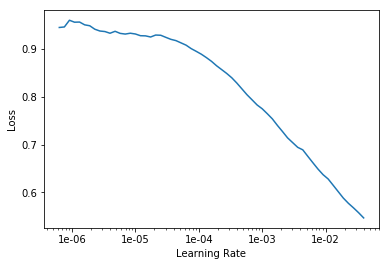

In [4]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,pixel,stable,ssim,psnr,time
0,0.267101,0.213769,0.232929,0.105201,0.094190,6.355774,03:48
1,0.112428,0.124536,0.137209,0.052722,0.182745,8.722319,03:52


In [ ]:
learn.save('rddb.1')


In [ ]:
movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*.czi'))
movie_files += list(Path('/scratch/bpho/datasources/low_res_test/').glob('low res confocal*.czi'))

In [ ]:
def image_from_tiles(learn, in_img, tile_sz=128, scale=4):
    cur_size = in_img.shape[1:3]
    c = in_img.shape[0]
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    w, h = cur_size
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((1,w*scale,h*scale))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = tensor(in_img[:,x_start:x_end, y_start:y_end])
            
            img_list = [Image(in_tile[i][None]) for i in range(3)]
            tlist = TransformableLists([img_list, img_list])
            out_tile,_,_ = learn.predict(tlist)
            
            out_x_start = x_start * scale
            out_x_end = x_end * scale
            out_y_start = y_start * scale
            out_y_end = y_end * scale

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = (x_end-x_start) * scale
            in_y_end = (y_end-y_start) * scale
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img

In [ ]:
def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128, wsize=3):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        
        
        data = czi_f.asarray()
        preds = []
        origs = []
        img_max = None
        for t in progress_bar(list(range(0,times-wsize+1))):
            idx = build_index(proc_axes, {'T': slice(t,t+wsize), 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            img /= img.max()
            
            out_img = image_from_tiles(learn, img, tile_sz=size)
            pred = (out_img*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (img[1][None]*255).astype(np.uint8)
            origs.append(orig)
            
        all_y = np.concatenate(preds)
        #print(all_y.shape)
        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)

In [ ]:
bs = 1
size = 512
data = get_data(bs, size, scale=4)

loss = TwoYLoss()
model = TwoXModel(MultiImageToMultiChannel(RRDB_Net(3, 1, nf, nb, gc=gcval )))
model = nn.DataParallel(model) 

learn = Learner(data, model, callback_fns=LossMetrics, loss_func=loss)
gc.collect()
learn = learn.load('rddb.1')

In [ ]:
for fn in movie_files:
    pred_name = f'{fn.stem}_pred.tif'
    orig_name = f'{fn.stem}_orig.tif'
    czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )